# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import os
import xml.etree.ElementTree as ET
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images
import time
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Object detection using VGG16Model

## Trail Train VGG16

In [ ]:
# Only for ecoch number


# Define the path to the directory containing the JPG and XML files
train_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/train/images'
valid_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/validation/images'

# Define the batch size
batch_size = 32

# Define the input shape of the model
input_shape = (416, 416, 3)

# Modify the loss function to smooth L1 loss
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
    loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

# Modify the metric to track mean IoU
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / (union + tf.keras.backend.epsilon())

# Load the MobileNetV2 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a custom output layer for bounding box regression (4 values)
x = base_model.output
x = Flatten()(x)
x = Dense(4, activation='linear')(x)  # 4 values for xmin, ymin, xmax, ymax
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with smooth L1 loss and mean IoU metric
model.compile(loss=smooth_l1_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[mean_iou])

# Define a callback to save the model with the highest validation mean IoU
class SaveBestModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        self.filepath = filepath
        self.highest_val_iou = 0.0

    def on_epoch_end(self, epoch, logs=None):
        val_iou = logs['val_mean_iou']

        if val_iou > self.highest_val_iou:
            # print(f"\nEpoch {epoch + 1}: val_mean_iou improved from {self.highest_val_iou:.5f} to {val_iou:.5f}, saving model to {self.filepath}")
            self.highest_val_iou = val_iou
            self.model.save(self.filepath)  # Save the model when the validation mean IoU improves
        # else:
        #     print(f"\nEpoch {epoch + 1}: val_mean_iou did not improve from {self.highest_val_iou:.5f}")

# Modify the ModelCheckpoint callback to monitor 'val_mean_iou' and save best model only
save_best = SaveBestModelCallback("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Modelv22.h5")

# Define a callback to track and print total training time and highest mean IoU
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.total_time = 0.0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.total_time += epoch_time
        print(f'\nTotal training time for epoch {epoch + 1}: {epoch_time:.2f} seconds')
        print(f'Loss: {logs["loss"]:.4f} ,   Val Loss: {logs["val_loss"]:.4f}')


# Define a data generator that yields batches of images and their corresponding annotations
def data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    train_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                             xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and train_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation)
                        data = []
                        train_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(train_annotation)

# Train the model with the timing callback and save the best model based on validation mean IoU
timing_callback = TimingCallback()
history = model.fit(data_generator(train_directory_path, batch_size, input_shape),
                    steps_per_epoch=len(os.listdir(train_directory_path)) // batch_size,
                    epochs=30,
                    verbose=1,
                    validation_data=data_generator(valid_directory_path, batch_size, input_shape),
                    validation_steps=len(os.listdir(valid_directory_path)) // batch_size,
                    callbacks=[save_best, timing_callback])

print(f'\nTotal training time end of {len(history.epoch)} epochs: {timing_callback.total_time:.2f} seconds')

Epoch 1/30
 6/14 [===========>..................] - ETA: 11s - loss: 2.9768 - mean_iou: -0.9638

14/14 [==============================] - ETA: 0s - loss: 1.3898 - mean_iou: -0.1351
Total training time for epoch 1: 28.43 seconds
Loss: 1.3898 ,   Val Loss: 0.0428
14/14 [==============================] - 28s 2s/step - loss: 1.3898 - mean_iou: -0.1351 - val_loss: 0.0428 - val_mean_iou: 0.6105
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0392 - mean_iou: 0.6278
Total training time for epoch 2: 23.45 seconds
Loss: 0.0392 ,   Val Loss: 0.0377
14/14 [==============================] - 23s 2s/step - loss: 0.0392 - mean_iou: 0.6278 - val_loss: 0.0377 - val_mean_iou: 0.6254
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.0286 - mean_iou: 0.6787
Total training time for epoch 3: 20.91 seconds
Loss: 0.0286 ,   Val Loss: 0.0334
14/14 [==============================] - 21s 1s/step - loss: 0.0286 - mean_iou: 0.6787 - val_loss: 0.0334 - val_mean_iou: 0.6190
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.0249 - mean_iou: 0.6972
Tot

## Train VGG16

In [3]:

# Define the path to the directory containing the JPG and XML files
train_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/train/images'
valid_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/validation/images'

# Define the path to the test directory containing the JPG and XML files
test_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/test/images'

# Define the batch size
batch_size = 32

# Define the input shape of the model
input_shape = (416, 416, 3)

# Modify the loss function to smooth L1 loss
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
    loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

# Modify the metric to track mean IoU
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / (union + tf.keras.backend.epsilon())

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a custom output layer for bounding box regression (4 values)
x = base_model.output
x = Flatten()(x)
x = Dense(4, activation='linear')(x)  # 4 values for xmin, ymin, xmax, ymax
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with smooth L1 loss and mean IoU metric
model.compile(loss=smooth_l1_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[mean_iou])

# Define a callback to save the model with the highest validation mean IoU
class SaveBestModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        self.filepath = filepath
        self.highest_val_iou = 0.0

    def on_epoch_end(self, epoch, logs=None):
        val_iou = logs['val_mean_iou']

        if val_iou > self.highest_val_iou:
            print(f"\nEpoch {epoch + 1}: val_mean_iou improved from {self.highest_val_iou:.5f} to {val_iou:.5f}, saving model to {self.filepath}")
            self.highest_val_iou = val_iou
            self.model.save(self.filepath)  # Save the model when the validation mean IoU improves
        else:
            print(f"\nEpoch {epoch + 1}: val_mean_iou did not improve from {self.highest_val_iou:.5f}")

# Modify the ModelCheckpoint callback to monitor 'val_mean_iou' and save best model only
save_best = SaveBestModelCallback("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# Define a callback to track and print total training time and highest mean IoU
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.total_time = 0.0
        self.highest_train_iou = 0.0
        self.highest_val_iou = 0.0
        self.highest_train_epoch = 0
        self.highest_val_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.total_time += epoch_time
        print(f'Total training time for epoch {epoch + 1}: {epoch_time:.2f} seconds')

        train_iou = logs['mean_iou']
        val_iou = logs['val_mean_iou']

        if train_iou > self.highest_train_iou:
            self.highest_train_iou = train_iou
            self.highest_train_epoch = epoch + 1

        if val_iou > self.highest_val_iou:
            self.highest_val_iou = val_iou
            self.highest_val_epoch = epoch + 1

        print(f'Highest training mean IoU: {self.highest_train_iou:.4f} at epoch {self.highest_train_epoch}')
        print(f'Highest validation mean IoU: {self.highest_val_iou:.4f} at epoch {self.highest_val_epoch}')

        print(f"Calculating metrics for epoch {epoch + 1}")

        test_generator = data_generator(test_directory_path, batch_size, input_shape)
        test_steps = len(os.listdir(test_directory_path)) // batch_size
        test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

        # Calculate test Precision and Recall for object detection
        precision, recall, y_true, y_pred = calculate_precision_recall_object_detection(model, test_generator, test_steps)
        precision_values.append(precision)
        recall_values.append(recall)

        confusion = multilabel_confusion_matrix(y_true, y_pred)
        confusion_matrices.append(confusion)
        print(f"Epoch {epoch + 1} - Average Precision: {np.mean(precision):.4f}, Average Recall: {np.mean(recall):.4f}")

# Define a data generator that yields batches of images and their corresponding annotations
def data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    train_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                             xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and train_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation)
                        data = []
                        train_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(train_annotation)
# Create a function to calculate Precision and Recall for object detection
def calculate_precision_recall_object_detection(model, data_generator, steps, threshold=0.5):
    y_true = []
    y_pred = []

    for i in range(steps):
        x, y = next(data_generator)
        predictions = model.predict(x)

        # Set a threshold to determine if an object is detected
        y_true.extend((y > 0).astype(int))
        y_pred.extend((predictions > threshold).astype(int))

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return precision, recall, y_true, y_pred

# Create lists to store precision and recall values for each epoch
precision_values = []
recall_values = []
confusion_matrices = []
test_loss = []
test_accuracy = []


# Train the model with the timing callback and save the best model based on validation mean IoU
timing_callback = TimingCallback()
history = model.fit(data_generator(train_directory_path, batch_size, input_shape),
                    steps_per_epoch=len(os.listdir(train_directory_path)) // batch_size,
                    epochs=30,
                    verbose=1,
                    validation_data=data_generator(valid_directory_path, batch_size, input_shape),
                    validation_steps=len(os.listdir(valid_directory_path)) // batch_size,
                    callbacks=[save_best, timing_callback])

print(f'Total training time end of {len(history.epoch)} epochs: {timing_callback.total_time:.2f} seconds')


Epoch 1/30
 6/14 [===========>..................] - ETA: 13s - loss: 2.8052 - mean_iou: -0.1536

14/14 [==============================] - ETA: 0s - loss: 1.2968 - mean_iou: 0.2642
Epoch 1: val_mean_iou improved from 0.00000 to 0.66563, saving model to /content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total training time for epoch 1: 101.37 seconds
Highest training mean IoU: 0.2642 at epoch 1
Highest validation mean IoU: 0.6656 at epoch 1
Calculating metrics for epoch 1
1/1 [==============================] - 0s 86ms/step
Epoch 1 - Average Precision: 1.0000, Average Recall: 0.5448
14/14 [==============================] - 117s 5s/step - loss: 1.2968 - mean_iou: 0.2642 - val_loss: 0.0352 - val_mean_iou: 0.6656
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0328 - mean_iou: 0.6544
Epoch 2: val_mean_iou improved from 0.66563 to 0.69807, saving model to /content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total training time for epoch 2: 26.31 seconds
Highest training mean IoU: 0.6544 at epoch 2
Highest validation mean IoU: 0.6981 at epoch 2
Calculating metrics for epoch 2
1/1 [==============================] - 0s 43ms/step
Epoch 2 - Average Precision: 0.8760, Average Recall: 0.5207
14/14 [==============================] - 32s 2s/step - loss: 0.0328 - mean_iou: 0.6544 - val_loss: 0.0320 - val_mean_iou: 0.6981
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.0253 - mean_iou: 0.6959
Epoch 3: val_mean_iou did not improve from 0.69807
Total training time for epoch 3: 23.24 seconds
Highest training mean IoU: 0.6959 at epoch 3
Highest validation mean IoU: 0.6981 at epoch 2
Calculating metrics for epoch 3
1/1 [==============================] - 0s 32ms/step
Epoch 3 - Average Precision: 0.5069, Average Recall: 0.4931
14/14 [==============================] - 29s 2s/step - loss: 0.0253 - mean_iou: 0.6959 - val_loss: 0.0260 - val_mean_iou: 0.6771
Epoch 4/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0217 - mean_iou: 0.7189
Epoch 4: val_mean_iou did not improve from 0.69807
Total training time for epoch 4: 23.29 seconds
Highest training mean IoU: 0.7189 at epoch 4
Highest validation mean IoU: 0.6981 at epoch 2
Calculating metrics for epoch 4
1/1 [==============================] - 0s 71ms/step
Epoch 4 - Average Precision: 0.5069, Average Recall: 0.4631
14/14 [==============================] - 30s 2s/step - loss: 0.0217 - mean_iou: 0.7189 - val_loss: 0.0293 - val_mean_iou: 0.6417
Epoch 5/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0190 - mean_iou: 0.7362
Epoch 5: val_mean_iou improved from 0.69807 to 0.70466, saving model to /content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total training time for epoch 5: 30.72 seconds
Highest training mean IoU: 0.7362 at epoch 5
Highest validation mean IoU: 0.7047 at epoch 5
Calculating metrics for epoch 5
1/1 [==============================] - 0s 45ms/step
Epoch 5 - Average Precision: 0.7521, Average Recall: 0.5069
14/14 [==============================] - 37s 3s/step - loss: 0.0190 - mean_iou: 0.7362 - val_loss: 0.0236 - val_mean_iou: 0.7047
Epoch 6/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0187 - mean_iou: 0.7345
Epoch 6: val_mean_iou improved from 0.70466 to 0.71528, saving model to /content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total training time for epoch 6: 26.71 seconds
Highest training mean IoU: 0.7362 at epoch 5
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 6
1/1 [==============================] - 0s 72ms/step
Epoch 6 - Average Precision: 0.7535, Average Recall: 0.5161
14/14 [==============================] - 32s 2s/step - loss: 0.0187 - mean_iou: 0.7345 - val_loss: 0.0253 - val_mean_iou: 0.7153
Epoch 7/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0199 - mean_iou: 0.7348
Epoch 7: val_mean_iou did not improve from 0.71528
Total training time for epoch 7: 22.85 seconds
Highest training mean IoU: 0.7362 at epoch 5
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 7
1/1 [==============================] - 0s 77ms/step
Epoch 7 - Average Precision: 0.7535, Average Recall: 0.4171
14/14 [==============================] - 29s 2s/step - loss: 0.0199 - mean_iou: 0.7348 - val_loss: 0.0339 - val_mean_iou: 0.6134
Epoch 8/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0207 - mean_iou: 0.7231
Epoch 8: val_mean_iou did not improve from 0.71528
Total training time for epoch 8: 23.12 seconds
Highest training mean IoU: 0.7362 at epoch 5
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 8
1/1 [==============================] - 0s 74ms/step
Epoch 8 - Average Precision: 1.0000, Average Recall: 0.5230
14/14 [==============================] - 30s 2s/step - loss: 0.0207 - mean_iou: 0.7231 - val_loss: 0.0259 - val_mean_iou: 0.7126
Epoch 9/30
14/14 [==============================] - ETA: 0s - loss: 0.0179 - mean_iou: 0.7410
Epoch 9: val_mean_iou did not improve from 0.71528
Total training time for epoch 9: 24.23 seconds
Highest training mean IoU: 0.7410 at epoch 9
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 9
1/1 [==============================] - 0s 97ms/step
Epoch 9 - Average Precision: 0.5069, Average Recall: 0.4931
14/14 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0142 - mean_iou: 0.7726
Epoch 10: val_mean_iou did not improve from 0.71528
Total training time for epoch 10: 22.73 seconds
Highest training mean IoU: 0.7726 at epoch 10
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 10
1/1 [==============================] - 0s 44ms/step
Epoch 10 - Average Precision: 0.5069, Average Recall: 0.4959
14/14 [==============================] - 28s 2s/step - loss: 0.0142 - mean_iou: 0.7726 - val_loss: 0.0239 - val_mean_iou: 0.6990
Epoch 11/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0122 - mean_iou: 0.7912
Epoch 11: val_mean_iou did not improve from 0.71528
Total training time for epoch 11: 23.08 seconds
Highest training mean IoU: 0.7912 at epoch 11
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 11
1/1 [==============================] - 0s 32ms/step
Epoch 11 - Average Precision: 0.7521, Average Recall: 0.4876
14/14 [==============================] - 29s 2s/step - loss: 0.0122 - mean_iou: 0.7912 - val_loss: 0.0247 - val_mean_iou: 0.6926
Epoch 12/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0108 - mean_iou: 0.8033
Epoch 12: val_mean_iou did not improve from 0.71528
Total training time for epoch 12: 23.05 seconds
Highest training mean IoU: 0.8033 at epoch 12
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 12
1/1 [==============================] - 0s 77ms/step
Epoch 12 - Average Precision: 1.0000, Average Recall: 0.5092
14/14 [==============================] - 30s 2s/step - loss: 0.0108 - mean_iou: 0.8033 - val_loss: 0.0244 - val_mean_iou: 0.7106
Epoch 13/30
14/14 [==============================] - ETA: 0s - loss: 0.0090 - mean_iou: 0.8184
Epoch 13: val_mean_iou did not improve from 0.71528
Total training time for epoch 13: 24.32 seconds
Highest training mean IoU: 0.8184 at epoch 13
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 13
1/1 [==============================] - 0s 72ms/step
Epoch 13 - Average Precision: 1.0000, Average Recall: 0.5000
14/14 [========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14/14 [==============================] - ETA: 0s - loss: 0.0076 - mean_iou: 0.8255
Epoch 17: val_mean_iou did not improve from 0.71528
Total training time for epoch 17: 23.76 seconds
Highest training mean IoU: 0.8472 at epoch 15
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 17
1/1 [==============================] - 0s 73ms/step
Epoch 17 - Average Precision: 1.0000, Average Recall: 0.5346
14/14 [==============================] - 31s 2s/step - loss: 0.0076 - mean_iou: 0.8255 - val_loss: 0.0283 - val_mean_iou: 0.6994
Epoch 18/30
14/14 [==============================] - ETA: 0s - loss: 0.0071 - mean_iou: 0.8322
Epoch 18: val_mean_iou did not improve from 0.71528
Total training time for epoch 18: 22.65 seconds
Highest training mean IoU: 0.8472 at epoch 15
Highest validation mean IoU: 0.7153 at epoch 6
Calculating metrics for epoch 18
1/1 [==============================] - 0s 44ms/step
Epoch 18 - Average Precision: 1.0000, Average Recall: 0.4904
14/14 [========

In [4]:
# List all the available keys in the history object
print(history.history.keys())


dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou'])


## Save training history

In [6]:
import pickle

# Save the history variable to a file
with open('/content/drive/MyDrive/CSE465 Project/VGG16Model/training_history.pickle', 'wb') as file:
    pickle.dump(history.history, file)


In [7]:
# If needed

# import pickle

# # Load the saved history from a file
# with open('training_history.pickle', 'rb') as file:
#     loaded_history = pickle.load(file)


## Precision-Recall Curve

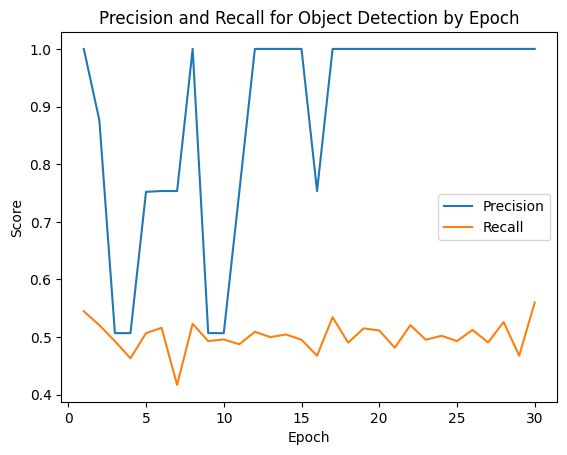

In [8]:
# Plot the Precision-Recall curves for each epoch
plt.figure()
plt.plot(range(1, 31), precision_values, label='Precision')
plt.plot(range(1, 31), recall_values, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall for Object Detection by Epoch')
plt.show()

## Plot the training and validation loss

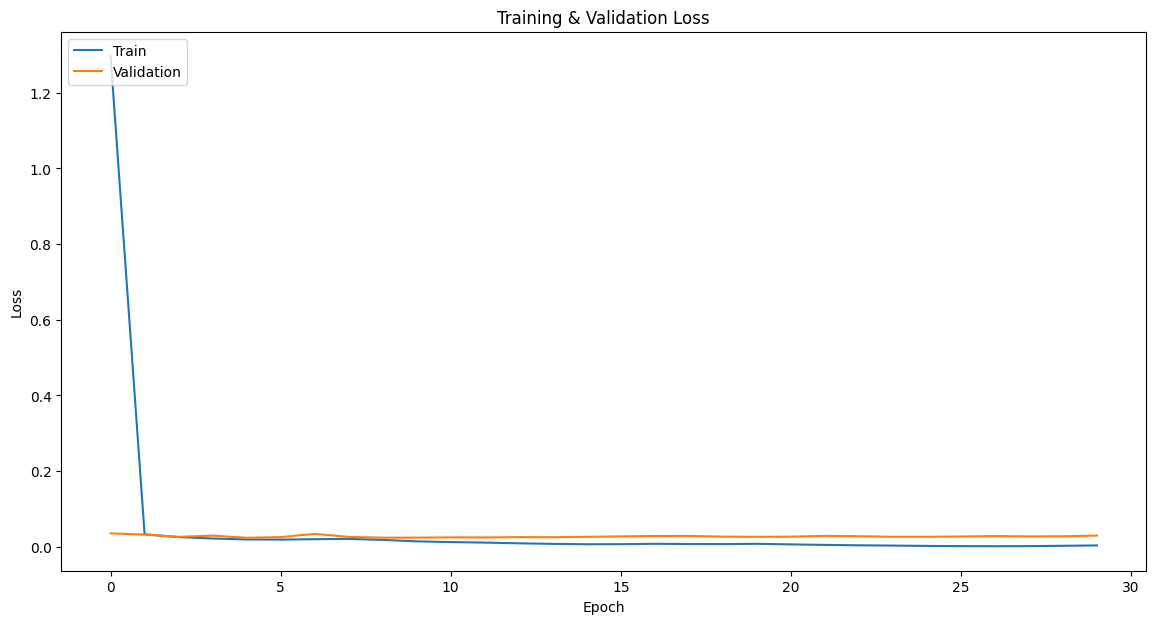

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Plot the training and validation mean IoU

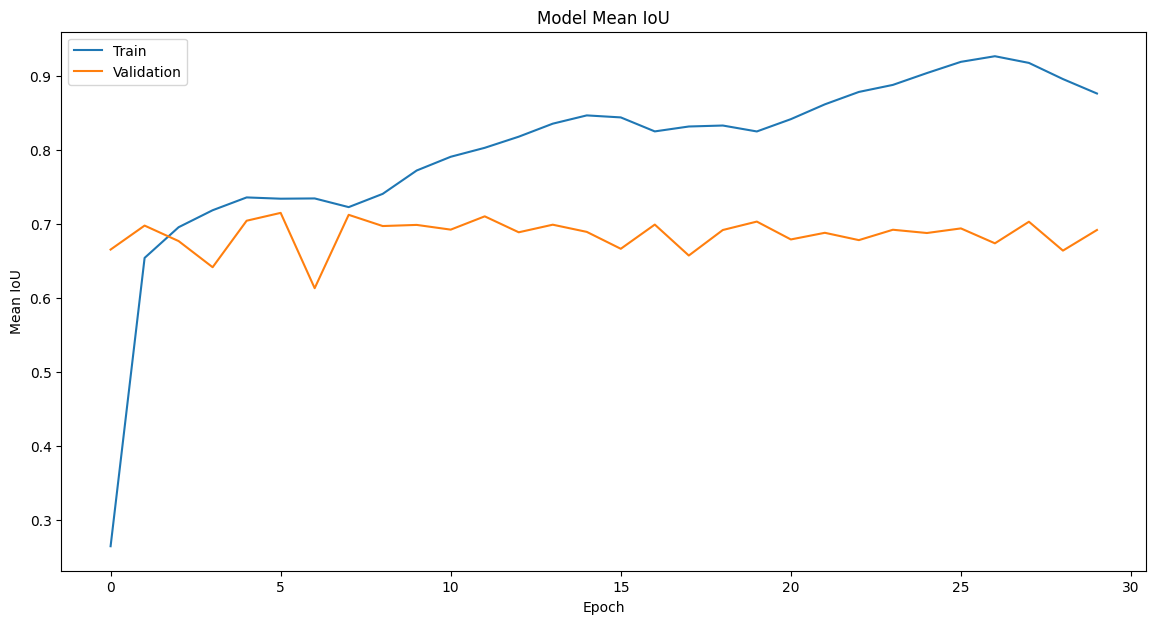

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Model Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix and Loss Values

In [20]:
# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# Evaluate the model on the test dataset
test_generator = data_generator(test_directory_path, batch_size, input_shape)
test_steps = len(os.listdir(test_directory_path)) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# Calculate test Precision and Recall for object detection
precision, recall, y_true, y_pred = calculate_precision_recall_object_detection(model, test_generator, test_steps)

confusion_matrices = []
confusion = multilabel_confusion_matrix(y_true, y_pred)
confusion_matrices.append(confusion)

print("\nConfusion Matrix:")
print(confusion_matrices)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision for Object Detection: {precision:.4f}")
print(f"Test Recall for Object Detection: {recall:.4f}\n")

1/1 [==============================] - 0s 29ms/step

Confusion Matrix:
[array([[[  4,   0],
        [152,   0]],

       [[  4,   0],
        [148,   4]],

       [[  0,   0],
        [  0, 156]],

       [[  0,   0],
        [  0, 156]]])]

Test Loss: 0.0234
Test Accuracy: 0.7282
Test Precision for Object Detection: 0.7532
Test Recall for Object Detection: 0.5130



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Trail the training and validation loss

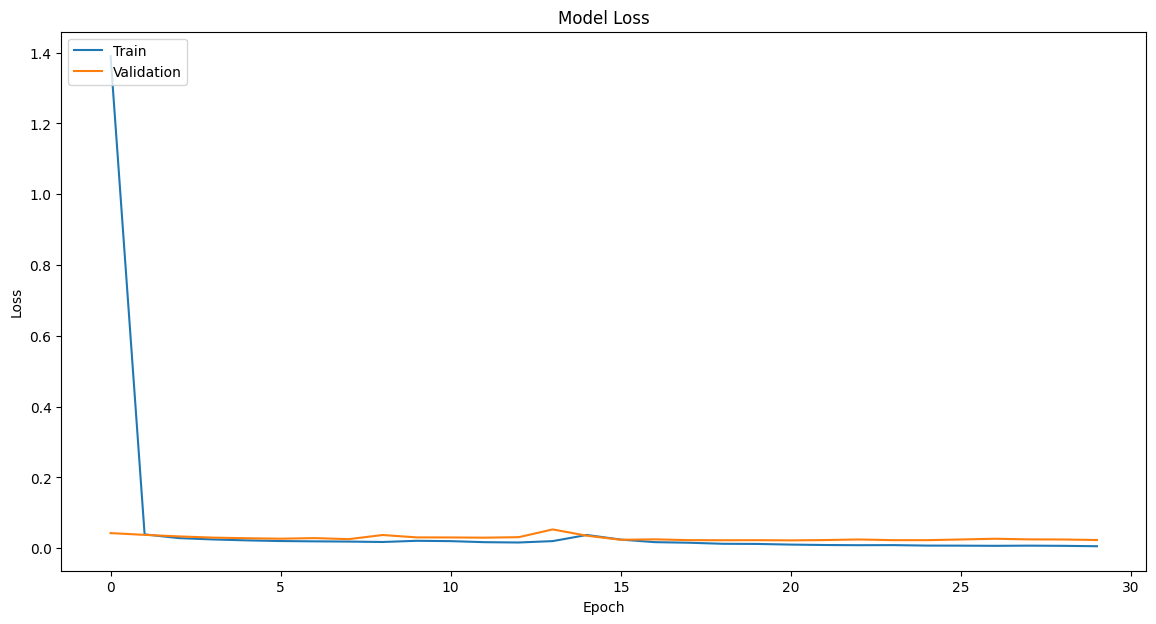

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Test dataset accuracy

In [14]:
# Define the custom loss function
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
    loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

# Define the custom metric function
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / (union + tf.keras.backend.epsilon())

# Register the custom functions
tf.keras.utils.get_custom_objects()["smooth_l1_loss"] = smooth_l1_loss
tf.keras.utils.get_custom_objects()["mean_iou"] = mean_iou

# Define the path to the test directory containing the JPG and XML files
test_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/test/images'

# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# Define a data generator for the test dataset
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)

# Evaluate the model on the test dataset
test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
test_steps = len(os.listdir(test_directory_path)) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 2s 385ms/step - loss: 0.0238 - mean_iou: 0.7199
Test Loss: 0.0238
Test Accuracy: 0.7199


## MSE MAE Smooth L1 IoU result

In [15]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import huber

# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# Define a data generator for the test dataset
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)

# Evaluate the model on the test dataset
test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
test_steps = len(os.listdir(test_directory_path)) // batch_size

# Get the predictions and true labels
y_true = []
y_pred = []
smooth_l1_losses = []

for i in range(test_steps):
    X_test, y_test = next(test_generator)
    y_true.extend(y_test.tolist())
    predictions = model.predict(X_test, verbose=0)
    y_pred.extend(predictions.tolist())

    # Convert y_true and y_pred to numpy arrays
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    # Calculate the Huber loss (smooth L1 loss)
    smooth_l1_loss = huber(y_true_np, y_pred_np).numpy()
    smooth_l1_losses.extend(smooth_l1_loss.tolist())

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Smooth L1 Loss
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mean_smooth_l1_loss = np.mean(smooth_l1_losses)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Smooth L1 Loss:", mean_smooth_l1_loss)

# Calculate Intersection over Union (IoU) for each bounding box
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    intersect_min_x = max(x1_min, x2_min)
    intersect_min_y = max(y1_min, y2_min)
    intersect_max_x = min(x1_max, x2_max)
    intersect_max_y = min(y1_max, y2_max)

    intersect_area = max(0, intersect_max_x - intersect_min_x + 1) * max(0, intersect_max_y - intersect_min_y + 1)

    box1_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
    box2_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)

    iou = intersect_area / float(box1_area + box2_area - intersect_area)
    return iou

# Calculate the average IoU over all bounding boxes
iou_scores = [calculate_iou(box1, box2) for box1, box2 in zip(y_true, y_pred)]
average_iou = np.mean(iou_scores)
print("Average Intersection over Union (IoU):", average_iou)


Mean Squared Error (MSE): 0.04764838802553686
Mean Absolute Error (MAE): 0.16959413441282314
Mean Smooth L1 Loss: 0.02359999101781155
Average Intersection over Union (IoU): 0.662273844327489


# Plot

## Precision-Recall curve

4/4 [==============================] - 3s 601ms/step - loss: 0.0258 - mean_iou: 0.7059

Test Loss: 0.0258
Test Accuracy: 0.7059
Test Precision for Object Detection: 1.0000
Test Recall for Object Detection: 0.5057



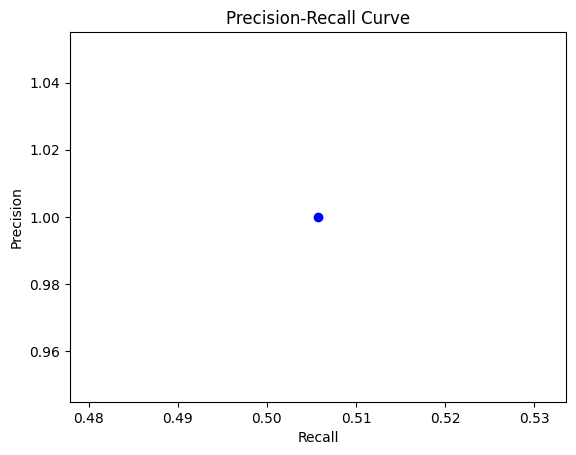

In [ ]:
# from sklearn.metrics import precision_score, recall_score
# import matplotlib.pyplot as plt


# # Define the custom loss function
# def smooth_l1_loss(y_true, y_pred):
#     diff = tf.abs(y_true - y_pred)
#     less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
#     loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
#     return tf.reduce_mean(loss)

# # Define the custom metric function
# def mean_iou(y_true, y_pred):
#     intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
#     union = tf.reduce_sum(tf.maximum(y_true, y_pred))
#     return intersection / (union + tf.keras.backend.epsilon())

# # Register the custom functions
# tf.keras.utils.get_custom_objects()["smooth_l1_loss"] = smooth_l1_loss
# tf.keras.utils.get_custom_objects()["mean_iou"] = mean_iou

# # Define the path to the test directory containing the JPG and XML files
# test_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/test/images'

# # Load the best saved model (or the model you want to evaluate)
# model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# # Define a data generator for the test dataset
# def test_data_generator(directory_path, batch_size, input_shape):
#     while True:
#         data = []
#         test_annotation = []
#         for filename in os.listdir(directory_path):
#             if filename.endswith('.jpg'):
#                 # Extract the file path of the JPG image
#                 image_path = os.path.join(directory_path, filename)
#                 # Construct the file path of the corresponding XML annotation file
#                 xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

#                 # Parse the XML annotation file
#                 tree = ET.parse(xml_path)
#                 root = tree.getroot()
#                 # Check if the bndbox element is present
#                 bndbox = root.find('object/bndbox')
#                 if bndbox is not None:
#                     # Extract the bounding box coordinates
#                     xmin = int(bndbox.find('xmin').text)
#                     xmax = int(bndbox.find('xmax').text)
#                     ymin = int(bndbox.find('ymin').text)
#                     ymax = int(bndbox.find('ymax').text)
#                     # Normalize the bounding box coordinates to the range [0, 1]
#                     test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
#                                             xmax / input_shape[0], ymax / input_shape[1]])

#                     # Load the image and preprocess it
#                     image = cv2.resize(cv2.imread(image_path), input_shape[:2])
#                     image = preprocess_input(image)
#                     data.append(image)

#                     # Yield the batch when the data and test_annotation lists are of length batch_size
#                     if len(data) == batch_size:
#                         yield np.array(data), np.array(test_annotation)
#                         data = []
#                         test_annotation = []

#         # Yield the last batch if it is smaller than batch_size
#         if len(data) > 0:
#             yield np.array(data), np.array(test_annotation)

# # Create a function to calculate Precision and Recall for object detection
# def calculate_precision_recall_object_detection(model, data_generator, steps, threshold=0.5):
#     y_true = []
#     y_pred = []

#     for i in range(steps):
#         x, y = next(data_generator)
#         predictions = model.predict(x)

#         # Set a threshold to determine if an object is detected
#         y_true.extend((y > 0).astype(int))
#         y_pred.extend((predictions > threshold).astype(int))

#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     return precision, recall, y_true, y_pred

# # Calculate test Precision and Recall for object detection
# precision, recall, y_true, y_pred = calculate_precision_recall_object_detection(model, test_generator, test_steps)

# # Evaluate the model on the test dataset
# test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
# test_steps = len(os.listdir(test_directory_path)) // batch_size
# test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# print(f"\nTest Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test Precision for Object Detection: {precision:.4f}")
# print(f"Test Recall for Object Detection: {recall:.4f}\n")


Calculating metrics for epoch 1
1/1 [==============================] - 0s 79ms/step
Epoch 1 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 2
1/1 [==============================] - 0s 94ms/step
Epoch 2 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 3
1/1 [==============================] - 0s 76ms/step
Epoch 3 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 4
1/1 [==============================] - 0s 74ms/step
Epoch 4 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 5
1/1 [==============================] - 0s 96ms/step
Epoch 5 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 6
1/1 [==============================] - 0s 75ms/step
Epoch 6 - Average Precision: 1.0000, Average Recall: 0.4977
Calculating metrics for epoch 7
1/1 [==============================] - 0s 80ms/step
Epoch 7 - Average Precision: 1.0000, Average Recall:

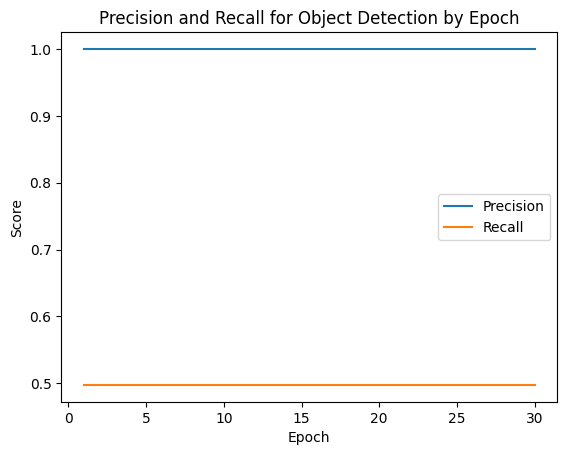

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Create a function to calculate Precision and Recall for object detection
def calculate_precision_recall_object_detection(model, data_generator, steps, threshold=0.5):
    y_true = []
    y_pred = []

    for i in range(steps):
        x, y = next(data_generator)
        predictions = model.predict(x)

        # Set a threshold to determine if an object is detected
        y_true.extend((y > 0).astype(int))
        y_pred.extend((predictions > threshold).astype(int))

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return precision, recall, y_true, y_pred

# Create lists to store precision and recall values for each epoch
precision_values = []
recall_values = []

# Iterate through epochs and calculate precision and recall for each epoch
for epoch in range(30):
    print(f"Calculating metrics for epoch {epoch + 1}")
    model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")
    test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
    test_steps = len(os.listdir(test_directory_path)) // batch_size

    precision, recall, _, _ = calculate_precision_recall_object_detection(model, test_generator, test_steps)
    precision_values.append(precision)
    recall_values.append(recall)
    print(f"Epoch {epoch + 1} - Average Precision: {np.mean(precision):.4f}, Average Recall: {np.mean(recall):.4f}")

# Plot the Precision-Recall curves for each epoch
plt.figure()
plt.plot(range(1, 31), precision_values, label='Precision')
plt.plot(range(1, 31), recall_values, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall for Object Detection by Epoch')
plt.show()


## Confusion Matrix

1/1 [==============================] - 0s 90ms/step
Confusion Matrix:
[[[  3   0]
  [102   5]]

 [[  3   0]
  [105   2]]

 [[  0   0]
  [  8 102]]

 [[  0   0]
  [  3 107]]]

Test Loss: 0.0258
Test Accuracy: 0.7059
Test Precision for Object Detection: 1.0000
Test Recall for Object Detection: 0.4977



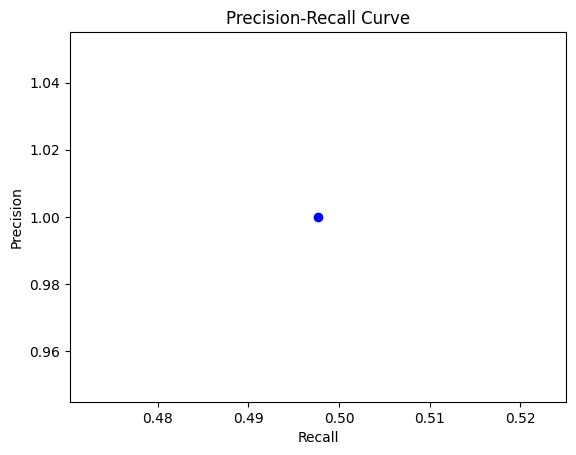

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Define the custom loss function
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
    loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

# Define the custom metric function
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / (union + tf.keras.backend.epsilon())

# Register the custom functions
tf.keras.utils.get_custom_objects()["smooth_l1_loss"] = smooth_l1_loss
tf.keras.utils.get_custom_objects()["mean_iou"] = mean_iou

# Define the path to the test directory containing the JPG and XML files
test_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/test/images'

# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5")

# Define a data generator for the test dataset
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)

# Create a function to calculate Precision and Recall for object detection
def calculate_precision_recall_object_detection(model, data_generator, steps, threshold=0.5):
    y_true = []
    y_pred = []

    for i in range(steps):
        x, y = next(data_generator)
        predictions = model.predict(x)

        # Set a threshold to determine if an object is detected
        y_true.extend((y > 0).astype(int))
        y_pred.extend((predictions > threshold).astype(int))

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return precision, recall, y_true, y_pred

# Evaluate the model on the test dataset
test_generator = test_data_generator(test_directory_path, 32, (416,416,3))
test_steps = len(os.listdir(test_directory_path)) // 32
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# Calculate test Precision and Recall for object detection
precision, recall, y_true, y_pred = calculate_precision_recall_object_detection(model, test_generator, test_steps)

confusion_matrices = []
confusion = multilabel_confusion_matrix(y_true, y_pred)
confusion_matrices.append(confusion)
print("Confusion Matrix:")
print(confusion)


print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision for Object Detection: {precision:.4f}")
print(f"Test Recall for Object Detection: {recall:.4f}\n")

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Prediction

## images test data

In [16]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Define the custom loss function
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), dtype=tf.float32)
    loss = less_than_one * 0.5 * diff ** 2 + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

# Define the custom metric function
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / (union + tf.keras.backend.epsilon())

# Register the custom functions
tf.keras.utils.get_custom_objects()["smooth_l1_loss"] = smooth_l1_loss
tf.keras.utils.get_custom_objects()["mean_iou"] = mean_iou

# Define a data generator that yields batches of test images and their corresponding annotations
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)


# Load the saved model
model_path = '/content/drive/MyDrive/CSE465 Project/VGG16Model/VGG16Model.h5'
Model = tf.keras.models.load_model(model_path)

# Define the path to the directory containing the test JPG files
test_directory_path = r'/content/drive/MyDrive/CSE465 Project/xml_dataset/test/images'

# Assuming you have 50 test samples, change this to the actual number of test samples
num_test_samples = 50

# Initialize the data generator for the test set
batch_size = 1  # Set the batch size for testing (you can adjust it as needed)
input_shape = (416, 416, 3)  # Set the input shape based on the model's input requirements
# Get the list of image file names in the test directory
test_image_files = [filename for filename in os.listdir(test_directory_path) if filename.endswith('.jpg')]

test_generator = test_data_generator(test_directory_path, batch_size, input_shape)

# Loop through the test dataset and make predictions
for i in range(num_test_samples):
    images, annotations = next(test_generator)
    xml_path = os.path.join(test_directory_path, test_image_files[i][:-4] + '.xml')

    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Find the class label from the XML annotation
    class_label = root.find('object/name').text

    # Extract the bounding box coordinates
    bndbox = root.find('object/bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)

    predictions = Model.predict(images)

    image = images[0].astype('uint8')  # Assuming batch size is 1
    # annotation = annotations[0]
    annotation = [xmin / input_shape[0], ymin / input_shape[1],
                  xmax / input_shape[0], ymax / input_shape[1]]
    pred = predictions[0]

    # Convert the normalized coordinates to pixel values for 224x224 input shape
    xmin, ymin, xmax, ymax = [int(anno * input_shape[i // 2]) for i, anno in enumerate(annotation)]
    xmin1, ymin1, xmax1, ymax1 = [int(p * input_shape[i // 2]) for i, p in enumerate(pred)]


    # Set the color of the bounding box based on the class label
    box_color = (255, 0, 0)  # Red color for Object

    cv2.rectangle(image, (xmin1, ymin1), (xmax1, ymax1), box_color, 3)
    cv2.putText(image, class_label, (xmin1, ymin1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
    plt.imshow(image)
    plt.title(f'Class: {class_label}')
    plt.show()

    box1 = [xmin, ymin, xmax, ymax]  # coordinates of the ground truth bounding box
    box2 = [xmin1, ymin1, xmax1, ymax1]  # coordinates of the predicted bounding box

    # Function to calculate the Intersection over Union (IoU)
    def calculate_iou(box1, box2):
        x5 = max(box1[0], box2[0])
        y5 = max(box1[1], box2[1])
        x6 = min(box1[2], box2[2])
        y6 = min(box1[3], box2[3])

        # calculate the area of intersection
        inter_area = max(0, x6 - x5) * max(0, y6 - y5)

        # calculate the area of union
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union_area = box1_area + box2_area - inter_area

        # calculate the IoU
        iou = inter_area / union_area
        return iou

    iou = calculate_iou(box1, box2)
    print(f"\nIoU for image {i+1}: {iou:.5f}")

Output hidden; open in https://colab.research.google.com to view.

## Videos test data

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET

batch_size = 1  # Set the batch size for testing (you can adjust it as needed)
input_shape = (416, 416, 3)  # Set the input shape based on the model's input requirements

# Define the directory path containing the video files
video_dir = '/content/drive/MyDrive/CSE465 Project/videos'

# Get a list of all the video files in the directory
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

# Define the model name
model_name = 'VGG16Model'

# Define a data generator that yields batches of frames and their corresponding annotations
def video_data_generator(video_path, batch_size, input_shape):
    cap = cv2.VideoCapture(video_path)
    while True:
        data = []
        video_frame = []
        while len(data) < batch_size:
            ret, frame = cap.read()
            if not ret:
                break  # Break the loop if the video ends

            video_frame.append(frame)
            if len(video_frame) == batch_size:
                # Preprocess the frames and add them to the data list
                data.extend([cv2.resize(frame, input_shape[:2]) for frame in video_frame])
                video_frame = []

        if len(data) == 0:
            break

        yield np.array(data)

    cap.release()

# Initialize the VideoWriter
output_shape = (input_shape[1], input_shape[0])  # Width, Height
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Loop through each video file
for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)

    # Initialize the data generator for the current video
    video_generator = video_data_generator(video_path, batch_size, input_shape)

    # Define the output video path for the current video
    output_video_dir = '/content/drive/MyDrive/CSE465 Project/VGG16Model_output'
    os.makedirs(output_video_dir, exist_ok=True)
    output_video_filename = f'{os.path.splitext(video_file)[0]}_{model_name}.mp4'
    output_video_path = os.path.join(output_video_dir, output_video_filename)

    # Initialize the VideoWriter for the current video
    output_video = cv2.VideoWriter(output_video_path, fourcc, 30.0, output_shape)

    # Loop through the video frames and make predictions for the current video
    try:
        while True:
            frames = next(video_generator)
            if len(frames) == 0:
                break  # Break the loop if there are no more frames

            predictions = Model.predict(frames)

            for frame_idx, frame in enumerate(frames):
                xml_path = os.path.join(test_directory_path, test_image_files[i][:-4] + '.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Find the class label from the XML annotation
                class_label = root.find('object/name').text

                # Extract the bounding box coordinates
                bndbox = root.find('object/bndbox')
                xmin = int(bndbox.find('xmin').text)
                xmax = int(bndbox.find('xmax').text)
                ymin = int(bndbox.find('ymin').text)
                ymax = int(bndbox.find('ymax').text)

                predictions = Model.predict(images)

                image = images[0].astype('uint8')  # Assuming batch size is 1
                # annotation = annotations[0]
                annotation = [xmin / input_shape[0], ymin / input_shape[1],
                              xmax / input_shape[0], ymax / input_shape[1]]

                pred = predictions[frame_idx]
                # Convert the normalized coordinates to pixel values for input shape
                xmin, ymin, xmax, ymax = [int(anno * input_shape[i // 2]) for i, anno in enumerate(annotation)]
                xmin1, ymin1, xmax1, ymax1 = [int(p * input_shape[i // 2]) for i, p in enumerate(pred)]



                # # Convert the normalized coordinates to pixel values for 224x224 input shape
                # xmin, ymin, xmax, ymax = [int(p * input_shape[i // 2]) for i, p in enumerate(pred)]


                # Set the color of the bounding box based on the class label
                box_color = (255, 0, 0 )  # Red color for Object

                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), box_color, 3)
                cv2.putText(frame, class_label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

                # Write the frame with annotations to the output video
                output_video.write(frame)

    except StopIteration:
        pass

    # Release the video writer and close the output video file for the current video
    output_video.release()


1/1 [==============================] - 0s 27ms/step
